## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
random_seed = 123

## Load data

In [ ]:
# Load data
sales = pd.read_excel("/content/drive/MyDrive/TFM/Datos/Datos.xlsx", sheet_name="Venta");
calendar = pd.read_excel("/content/drive/MyDrive/TFM/Datos/Datos.xlsx", sheet_name="Calendario");
promotions = pd.read_excel("/content/drive/MyDrive/TFM/Datos/Datos.xlsx", sheet_name="Promociones");
stock = pd.read_excel("/content/drive/MyDrive/TFM/Datos/Datos.xlsx", sheet_name="Stock");
suply = pd.read_excel("/content/drive/MyDrive/TFM/Datos/DatosCicloAprovisionamiento.xlsx");
price = pd.read_excel("/content/drive/MyDrive/TFM/Datos/DatosPrecioMedio.xlsx");

Understaing data loaded.

In [ ]:
sales.shape, calendar.shape, promotions.shape, stock.shape, suply.shape, price.shape

((707608, 3), (830, 3), (26087, 3), (707608, 3), (1000, 3), (1000, 2))

In [ ]:
sales.head(), calendar.head(), promotions.head(), stock.head(), suply.head(), price.head()

(   producto  idSecuencia  udsVenta
 0         1     20210403        11
 1         1     20210404         0
 2         1     20210405         0
 3         1     20210406        16
 4         1     20210407        21,
    idSecuencia  bolOpen  bolHoliday
 0     20220524        1           0
 1     20230323        1           0
 2     20230324        1           0
 3     20230329        1           0
 4     20230330        1           0,
    producto  idSecuenciaIni  idSecuenciaFin
 0       577        20141029        20141121
 1       836        20210715        20210815
 2       829        20150410        20150611
 3       156        20170420        20170520
 4        48        20160714        20160815,
    producto  idSecuencia  udsStock
 0       222     20210404        68
 1       222     20210405        68
 2       222     20210406        68
 3       222     20210407        85
 4       222     20210408        85,
    producto  diasEntrePedidos  diasLeadtime
 0         1               

## Functions

In [ ]:
def get_first_day_week(day):
  if isinstance(day, pd.Timestamp):
    day = day.strftime('%d/%b/%Y')

  dt = datetime.strptime(day, '%d/%b/%Y')
  start = dt - timedelta(days=dt.weekday())
  return start

def verify_promotion_date(row, promotions, postprom=7):
  """
  For each row, return if the product has an active promotion or not

  Inputs:
  - row: Row containing product ID and date, also demand, etc.s3
  - promotions: Dataframe containing product ID and promotion start and end

  Outputs:
  - Integer. 0 if there isn't an active promotion, 1 otherwise.
  """

  product = row['producto'];
  id_seq = row['idSecuencia'];

  cond_df = promotions.loc[(promotions['producto'] == product) & (id_seq >= promotions['idSecuenciaIni']) & (id_seq <= promotions['idSecuenciaFin'])];

  if not cond_df.empty:
    promotion_duration = (pd.to_datetime(cond_df['idSecuenciaFin'], format='%Y%m%d') - pd.to_datetime(cond_df['idSecuenciaIni'], format='%Y%m%d')).dt.days
    return 1, promotion_duration.iloc[0], 0;

  endPromotionDates = pd.to_datetime(promotions['idSecuenciaFin'], format='%Y%m%d')
  date = pd.to_datetime(row['idSecuencia'], format='%Y%m%d')
  cond_2_df = promotions.loc[(promotions['producto'] == product) & (date >= endPromotionDates) & (date <= endPromotionDates+timedelta(days=postprom))];
  if not cond_2_df.empty:
    return 0, 0, 1;

  return 0, 0, 0;

def create_product_lagged_matrix(data, producto, file, n_lags=10):
  """
  Create a lagged matrix for time series forecasting and save into a file.

  Inputs:
  - timeseries: Array or column with time series data.
  - n_lags: Number of lag time steps to create.

  Outputs:
  - X: Lagged matrix.
  - y: Target values.
  """
  import os
  from csv import writer

  with open(file, 'a') as f_object:
    writer_object = writer(f_object)

    column_names = data.columns;
    lagged_column_names = ['y', 't-7']

    for i in range(1, n_lags):
      lagged_column_names.append(f"t-{n_lags-i}")

    column_names = lagged_column_names + list(data.columns)

    ## Write column names
    # Check if file is empty
    file_size = os.path.getsize(file)

    if file_size == 0:
      writer_object.writerow(column_names) # Write column names at first

    X, y = [], []
    timeseries = np.array(data.loc[data['producto'] == producto, 'udsVenta'])
    data = data.loc[data['producto'] == producto]

    for i in range(0, len(timeseries)-n_lags-1):
      X = np.concatenate([timeseries[i:(i+n_lags)].flatten(), np.array(data.iloc[(i+n_lags)])])
      y = (timeseries[(i+n_lags)])
      X, y = np.array(X), np.array(y)
      row = np.insert(X, 0, y)
      writer_object.writerow(row) # Write data rows

  return None

def plot_product_demand(data, products):
  """
  Plot daily and monthly agregated data for each one of the products selected.

  Inputs:
  - data: Complete dataset of products, demand, etc.
  - products: List of products to plot
  """
  for product_id in products:
    product_data = data[(data['producto'] == product_id)&(data['bolOpen'] == 1)]
    monthly_aggregated = product_data.groupby([product_data['year'], product_data['month']])['udsVenta'].sum().reset_index()

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 6))
    daily_demand, = ax1.plot(product_data['date'], product_data['udsVenta'], marker='o', linestyle='-', label=product_id)
    ax2 = ax1.twinx()
    monthly_demand, = ax2.plot(pd.to_datetime(monthly_aggregated[['year', 'month']].assign(day=1)), monthly_aggregated['udsVenta'], marker='o', linestyle='-', color='tab:red', label='Monthly')

    # Highlight promotional days with a different color
    promo_days_mask = product_data['promActive'] == 1
    ax1.plot(product_data.loc[promo_days_mask, 'date'], product_data.loc[promo_days_mask, 'udsVenta'],
             marker='o', linestyle='-', color='orange', label='Promotional Days')

    # Customize the plot
    plt.title(f'Demand for product with ID {product_id}')
    plt.xlabel('Time')
    ax1.set_ylabel('Demand')
    ax2.set_ylabel('Monthly demand')
    plt.legend([daily_demand, monthly_demand], ['Daily', 'Monthly'])
    plt.grid(True)

    # Show the plot
    plt.show()

def plot_product_zero_demand_and_stock_outs(data, products):
  """
  Plot an histogram of zero demand periods and stock-outs periods for
  products selected

  Inputs:
  - data: Complete dataset of products, demand, etc.
  - products: List of products to plot
  """
  total_zero_demand_counts = [];
  total_stockout_counts = [];
  total_zero_demand_open_counts = [];

  for product_id in products:
    product_data = data[data['producto'] == product_id]

    # Count zero demands
    zero_demand_count = product_data[product_data['udsVenta'] == 0].size

    # Count zero demand at open day
    zero_demand_open_count = product_data.loc[(product_data['udsVenta'] == 0)&(product_data['bolOpen'] == 1)].size

    # Count stock-outs
    stockout_count = product_data[product_data['udsStock'] == 0].size

    # Update total counters
    total_zero_demand_counts.append(zero_demand_count)
    total_stockout_counts.append(stockout_count)
    total_zero_demand_open_counts.append(zero_demand_open_count)

  fig, ax = plt.subplots(figsize=(14, 6))

  ax.bar(np.linspace(0, len(products)-1, num=len(products))-0.1, total_zero_demand_counts, label='Zero demand', width=0.2)
  ax.bar(np.linspace(0, len(products)-1, num=len(products))-0.1, total_zero_demand_open_counts, label='Zero demand at open day', width=0.2)
  ax.bar(np.linspace(0, len(products)-1, num=len(products))+0.1, total_stockout_counts, label='Stock-outs', width=0.2)
  ax.set_title('Histogram of Total Zero Demand and Stock-outs')
  ax.set_xlabel('Product')
  ax.set_ylabel('Count')
  ax.legend()

  plt.show();

def plot_product_boxplots(data, products):
  """
  Plot boxplots of daily demand for products selected, to show quartiles,
  median, minimum, maximum and possible outliers.

  Inputs:
  - data: Complete dataset of products, demand, etc.
  - products: List of products to plot
  """
  boxplot_data = []
  for product_id in products:
    product_data = data.loc[(data['producto'] == product_id)&(data['bolOpen'] == 1), 'udsVenta']
    boxplot_data.append(product_data)


  fig, ax = plt.subplots(figsize =(10, 7))
  ax.set_xticks(range(1, len(products) + 1))
  ax.set_xticklabels(products)
  ax.set_title('Products boxplot for daily demand')
  ax.set_xlabel('Product')
  ax.set_ylabel('Units sold')
  ax.boxplot(boxplot_data)

  # Show the plot
  plt.show()

In [ ]:
sales.head()

,producto,idSecuencia,udsVenta
0,1,20210403,11
1,1,20210404,0
2,1,20210405,0
3,1,20210406,16
4,1,20210407,21


In [ ]:
length_counts = sales.groupby('producto').size().value_counts().reset_index()
length_counts.columns = ['length', 'count']
total_counts = length_counts['count'].sum()
length_counts.head()

,length,count
0,731,968


All timeseries, for each product, has the same length.

## Daily datasets

Generating new features and merging dataframes.

In [ ]:
dataset = sales.merge(calendar, on='idSecuencia', how='left')
dataset = dataset.merge(stock, on=['idSecuencia', 'producto'], how='left')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707608 entries, 0 to 707607
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   producto     707608 non-null  int64  
 1   idSecuencia  707608 non-null  int64  
 2   udsVenta     707608 non-null  int64  
 3   bolOpen      706640 non-null  float64
 4   bolHoliday   706640 non-null  float64
 5   udsStock     706640 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 37.8 MB


In [ ]:
# Adding promotion features
print(dataset.shape)
dataset[['promActive', 'promDuration', 'postPromPeriod']] = dataset.apply(lambda x: pd.Series(verify_promotion_date(x, promotions)), axis=1)
print(dataset.shape)

(707608, 6)
(707608, 9)


In [ ]:
# Adding date features
dataset['date'] = pd.to_datetime(dataset['idSecuencia'], format='%Y%m%d')
# Create new columns for year, month, and day
dataset['year'] = dataset['date'].dt.year
dataset['month'] = dataset['date'].dt.month
dataset['monthDay'] = dataset['date'].dt.day
dataset['weekDay'] = dataset['date'].dt.dayofweek
dataset['yearDay'] = dataset['date'].dt.dayofyear

dataset.head()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,udsStock,promActive,promDuration,postPromPeriod,date,year,month,monthDay,weekDay,yearDay
0,1,20210403,11,NaN,NaN,NaN,1,27,0,2021-04-03,2021,4,3,5,93
1,1,20210404,0,0.0,1.0,217.0,1,27,0,2021-04-04,2021,4,4,6,94
2,1,20210405,0,0.0,1.0,217.0,1,27,0,2021-04-05,2021,4,5,0,95
3,1,20210406,16,1.0,0.0,217.0,1,27,0,2021-04-06,2021,4,6,1,96
4,1,20210407,21,1.0,0.0,199.0,1,27,0,2021-04-07,2021,4,7,2,97


In [ ]:
dataset.describe()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,udsStock,promActive,promDuration,postPromPeriod,year,month,monthDay,weekDay,yearDay
count,707608.000000,7.076080e+05,707608.000000,706640.000000,706640.000000,706640.000000,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000
mean,499.500000,2.021821e+07,1.424344,0.843836,0.176712,45.674130,0.242486,6.772289,0.044412,2021.753762,6.522572,15.703146,3.002736,182.876881
std,289.284031,6.469619e+03,2.451962,0.363011,0.381425,47.256144,0.428587,12.156414,0.206008,0.663364,3.446759,8.802799,2.003417,105.346542
min,1.000000,2.021040e+07,-117.000000,0.000000,0.000000,-53.000000,0.000000,0.000000,0.000000,2021.000000,1.000000,1.000000,0.000000,1.000000
25%,247.750000,2.021100e+07,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000,0.000000,2021.000000,4.000000,8.000000,1.000000,92.000000
50%,499.500000,2.022040e+07,0.000000,1.000000,0.000000,37.000000,0.000000,0.000000,0.000000,2022.000000,7.000000,16.000000,3.000000,183.000000
75%,750.250000,2.022100e+07,2.000000,1.000000,0.000000,52.000000,0.000000,0.000000,0.000000,2022.000000,10.000000,23.000000,5.000000,274.000000
max,1000.000000,2.023040e+07,183.000000,1.000000,1.000000,885.000000,1.000000,41.000000,1.000000,2023.000000,12.000000,31.000000,6.000000,365.000000


In [ ]:
dataset[(dataset['udsVenta']<0)].head()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,udsStock,promActive,promDuration,postPromPeriod,date,year,month,monthDay,weekDay,yearDay
6299,9,20220628,-36,1.0,0.0,66.0,0,0,0,2022-06-28,2022,6,28,1,179
6311,9,20220710,-36,0.0,1.0,82.0,0,0,0,2022-07-10,2022,7,10,6,191
6354,9,20220822,-62,1.0,0.0,0.0,0,0,0,2022-08-22,2022,8,22,0,234
14175,21,20220114,-23,1.0,0.0,85.0,1,41,0,2022-01-14,2022,1,14,4,14
15565,23,20211103,-2,1.0,0.0,41.0,0,0,0,2021-11-03,2021,11,3,2,307


In [ ]:
# Treat negative sales and stock
dataset.loc[dataset['udsVenta']<0, 'udsVenta'] = 0
dataset.loc[dataset['udsStock']<0, 'udsStock'] = 0

dataset.head()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,udsStock,promActive,promDuration,postPromPeriod,date,year,month,monthDay,weekDay,yearDay
0,1,20210403,11,NaN,NaN,NaN,1,27,0,2021-04-03,2021,4,3,5,93
1,1,20210404,0,0.0,1.0,217.0,1,27,0,2021-04-04,2021,4,4,6,94
2,1,20210405,0,0.0,1.0,217.0,1,27,0,2021-04-05,2021,4,5,0,95
3,1,20210406,16,1.0,0.0,217.0,1,27,0,2021-04-06,2021,4,6,1,96
4,1,20210407,21,1.0,0.0,199.0,1,27,0,2021-04-07,2021,4,7,2,97


In [ ]:
# NaN treatment
# dataset = dataset.fillna(method='backfill') # NaN are filled with next valid value
dataset = dataset.dropna()

dataset.head()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,udsStock,promActive,promDuration,postPromPeriod,date,year,month,monthDay,weekDay,yearDay
1,1,20210404,0,0.0,1.0,217.0,1,27,0,2021-04-04,2021,4,4,6,94
2,1,20210405,0,0.0,1.0,217.0,1,27,0,2021-04-05,2021,4,5,0,95
3,1,20210406,16,1.0,0.0,217.0,1,27,0,2021-04-06,2021,4,6,1,96
4,1,20210407,21,1.0,0.0,199.0,1,27,0,2021-04-07,2021,4,7,2,97
5,1,20210408,4,1.0,0.0,178.0,0,0,1,2021-04-08,2021,4,8,3,98


Exploring and visualizing data.

In [ ]:
# Get CV2 and ADI (Spiliotis et al., 2022)
demand = []
for producto in dataset['producto'].unique():
    data = dataset[(dataset['producto']==producto)&(dataset['bolOpen']==1)]
    data['udsVenta'] = data['udsVenta'].replace(0, np.nan)

    # Calcular ADI (Average Interdemand Interval)
    adi = len(data) / len(data[data['udsVenta'] > 0])

    # Calcular CV2
    data = data['udsVenta'].dropna()
    cv2 = (np.sqrt(np.var(data)) / np.mean(data))**2

    demand.append({
        'producto': producto,
        'ADI': adi,
        'CV2': cv2
    })

# Crear un DataFrame con los resultados
demand_df = pd.DataFrame(demand)
demand_df.head()

<ipython-input-17-4e1b93460d0d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['udsVenta'] = data['udsVenta'].replace(0, np.nan)


,producto,ADI,CV2
0,1,1.144981,0.318285
1,2,1.060241,0.313052
2,3,1.217391,0.728580
3,4,1.259714,0.404304
4,5,1.198444,0.403349


In [ ]:
dataset = dataset.merge(demand_df, on='producto', how='left')

# Secure timeseries is sorted by product and date ascending
dataset = dataset.sort_values(['producto', 'idSecuencia'], ascending=True);
dataset.head()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,udsStock,promActive,promDuration,postPromPeriod,date,year,month,monthDay,weekDay,yearDay,ADI,CV2
0,1,20210404,0,0.0,1.0,217.0,1,27,0,2021-04-04,2021,4,4,6,94,1.144981,0.318285
1,1,20210405,0,0.0,1.0,217.0,1,27,0,2021-04-05,2021,4,5,0,95,1.144981,0.318285
2,1,20210406,16,1.0,0.0,217.0,1,27,0,2021-04-06,2021,4,6,1,96,1.144981,0.318285
3,1,20210407,21,1.0,0.0,199.0,1,27,0,2021-04-07,2021,4,7,2,97,1.144981,0.318285
4,1,20210408,4,1.0,0.0,178.0,0,0,1,2021-04-08,2021,4,8,3,98,1.144981,0.318285


<ipython-input-19-3dcebed7f5af>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(dataset.corr(), cmap="YlGnBu", annot=True, fmt=".2f")


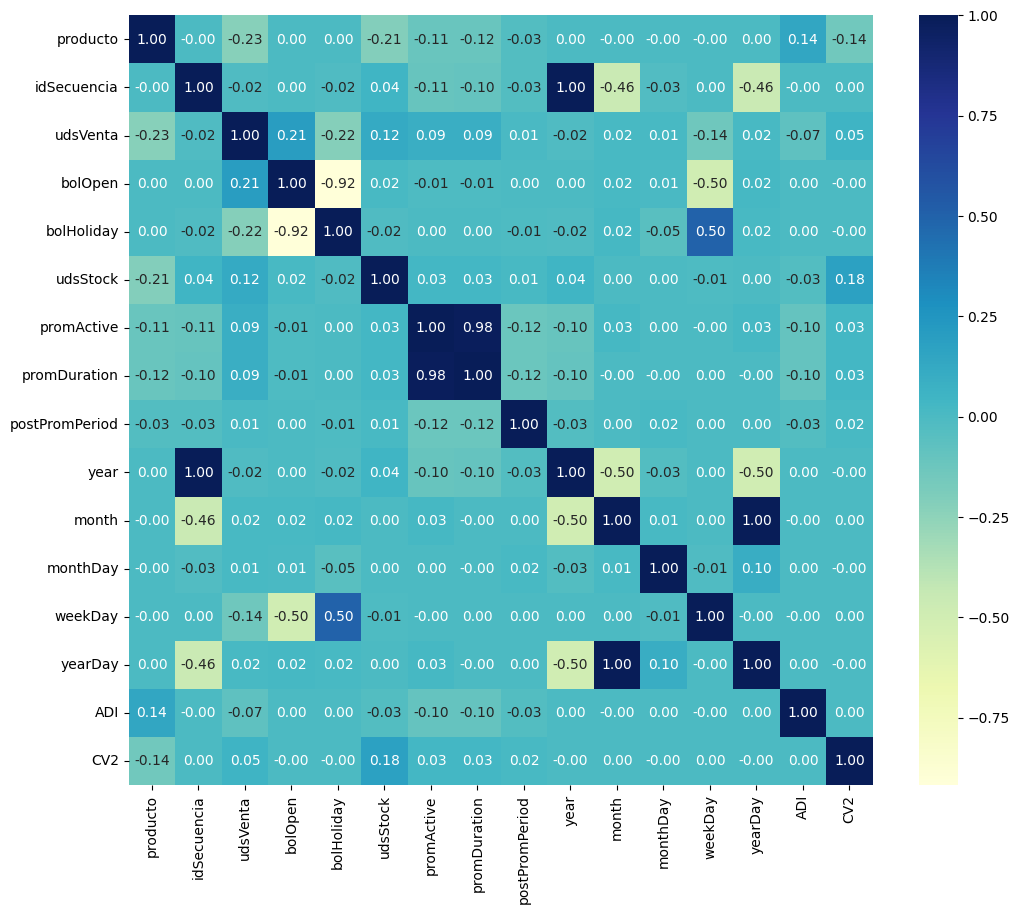

In [ ]:
# Seaborn correlation matrix
plt.figure(figsize=(12, 10))
sb.heatmap(dataset.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.show()

In [ ]:
intermittent_series = demand_df[(demand_df['ADI']>(4/3))&(demand_df['CV2']<0.5)]
lumpy_series = demand_df[(demand_df['ADI']>(4/3))&(demand_df['CV2']>0.5)]
smooth_series = demand_df[(demand_df['ADI']<(4/3))&(demand_df['CV2']<0.5)]
erratic_series = demand_df[(demand_df['ADI']<(4/3))&(demand_df['CV2']>0.5)]

len(intermittent_series), len(lumpy_series), len(smooth_series), len(erratic_series)

(873, 40, 51, 4)

Most of them are intermittent time series.

Intermittent


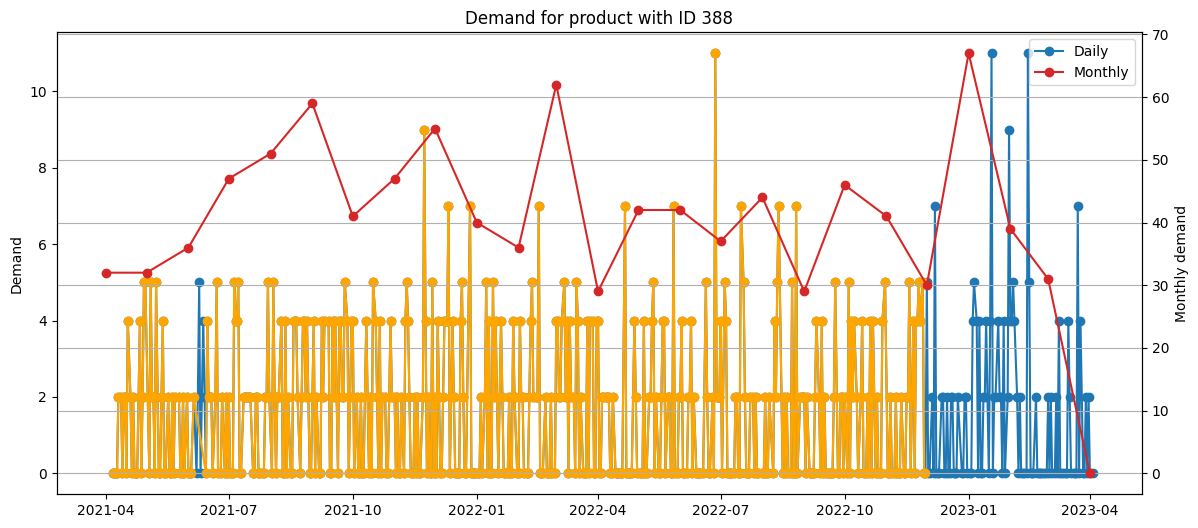

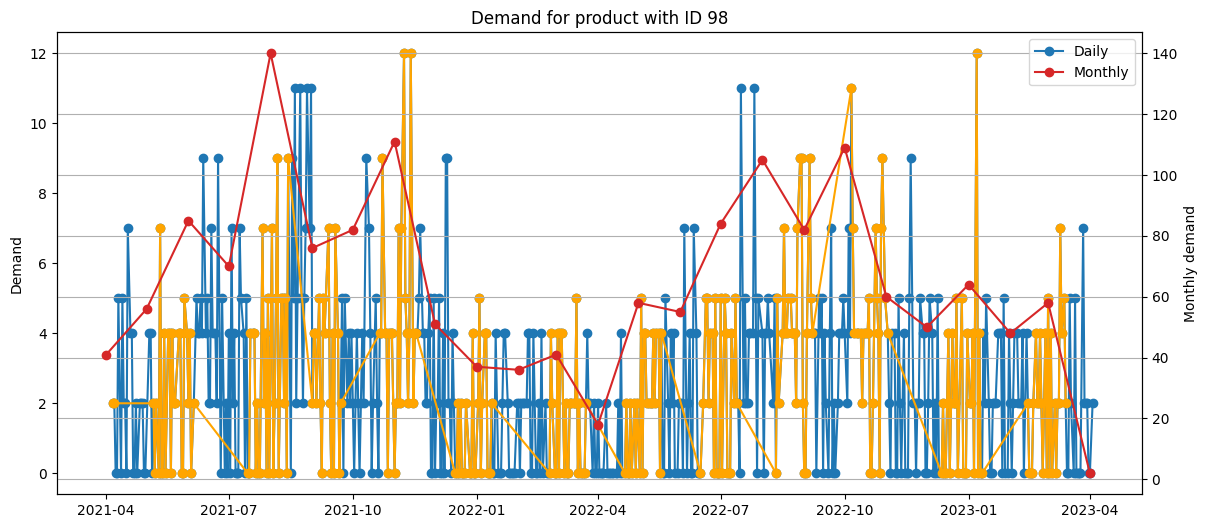

In [ ]:
random_intermittent = intermittent_series['producto'].sample(n=2, random_state=random_seed).tolist()
random_lumpy = lumpy_series['producto'].sample(n=2, random_state=random_seed).tolist()
random_smooth = smooth_series['producto'].sample(n=2, random_state=random_seed).tolist()
random_erratic = erratic_series['producto'].sample(n=2, random_state=random_seed).tolist()

print('Intermittent')
plot_product_demand(dataset, random_intermittent)

Lumpy


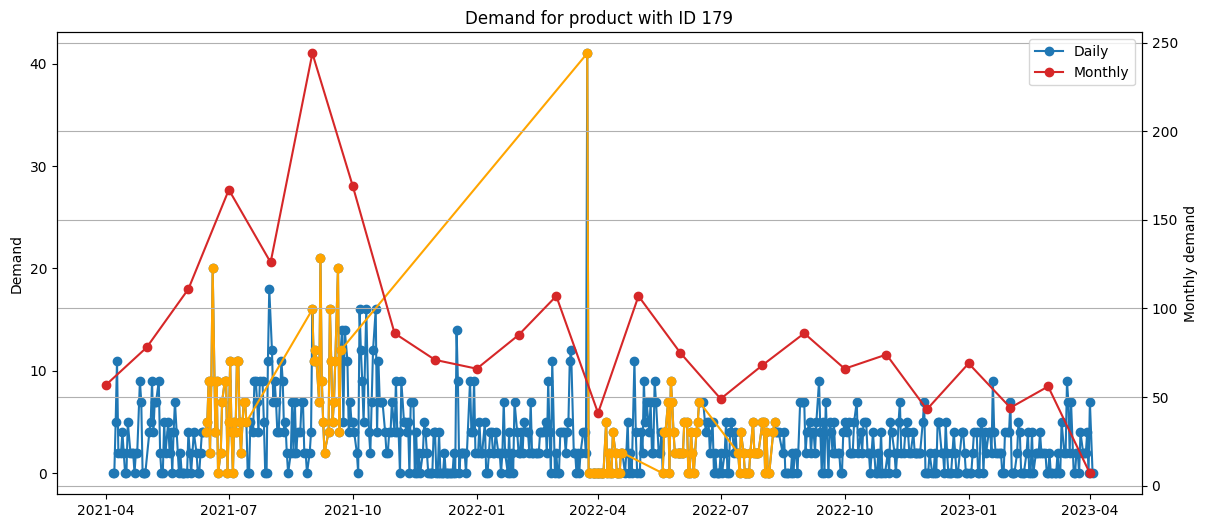

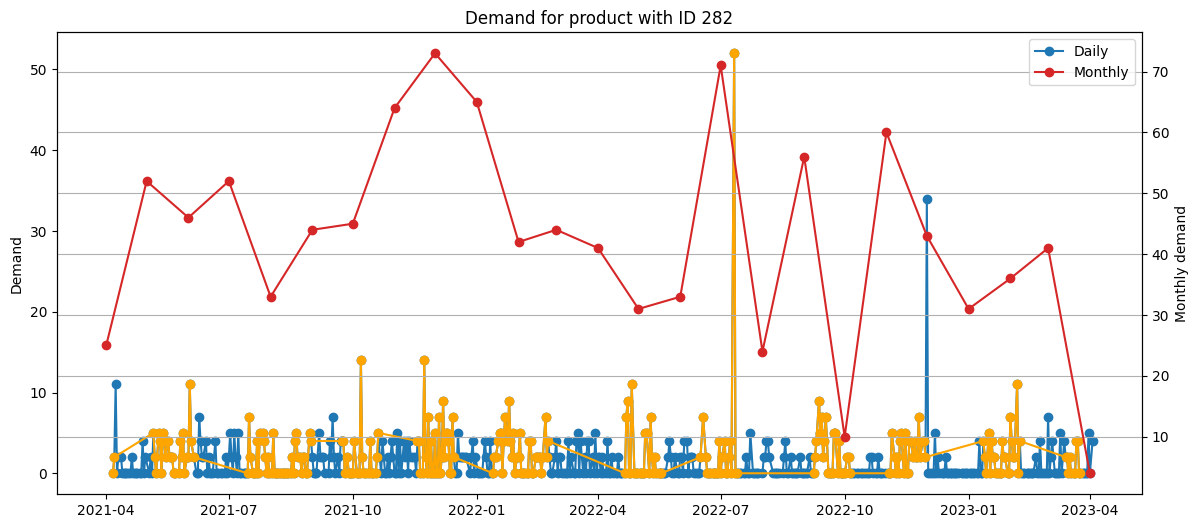

In [ ]:
print('Lumpy')
plot_product_demand(dataset, random_lumpy)

Smooth


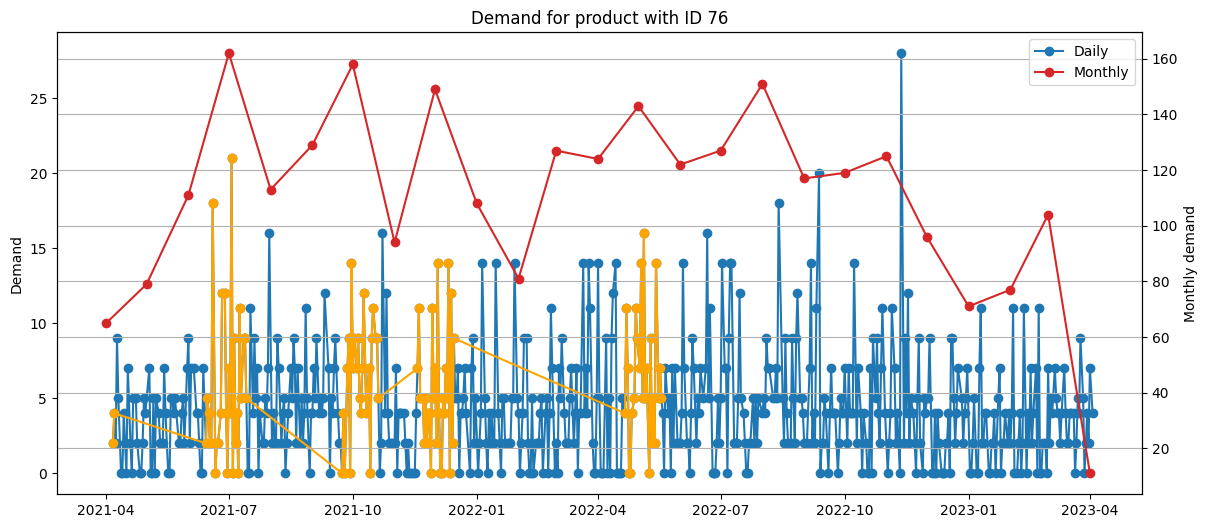

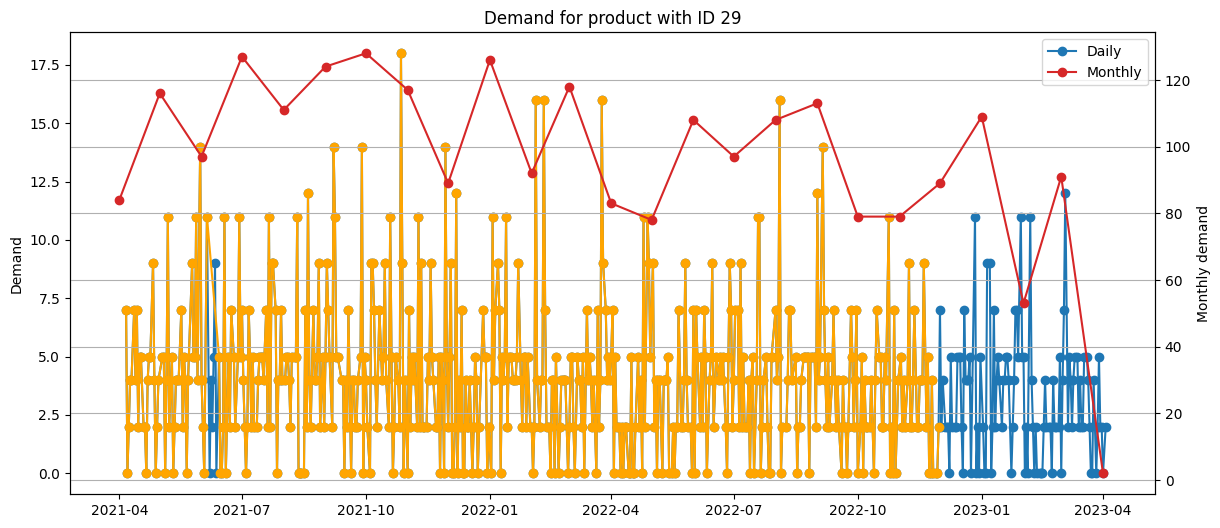

In [ ]:
print('Smooth')
plot_product_demand(dataset, random_smooth)


Erratic


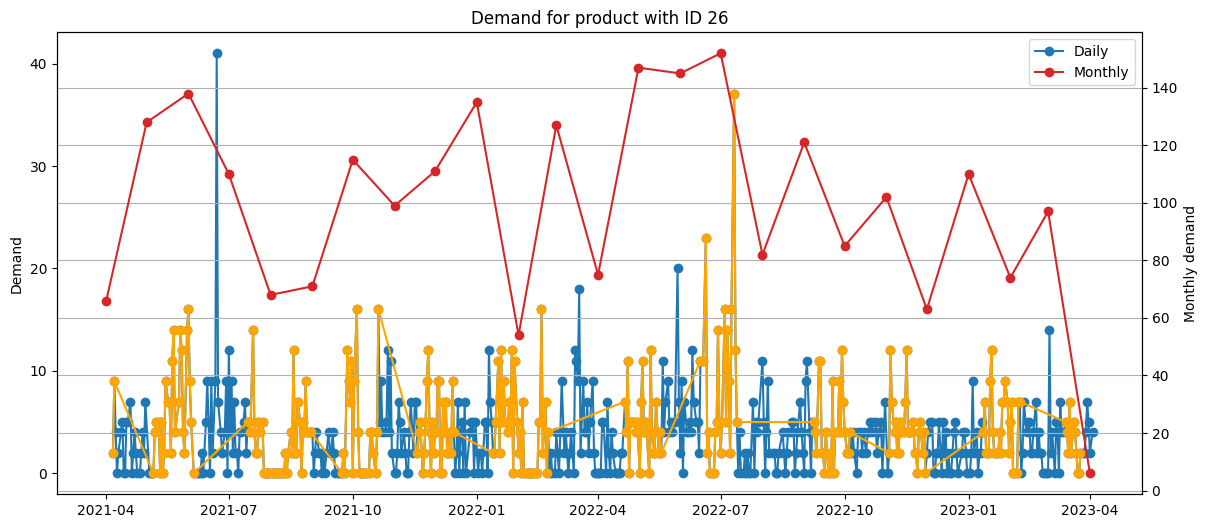

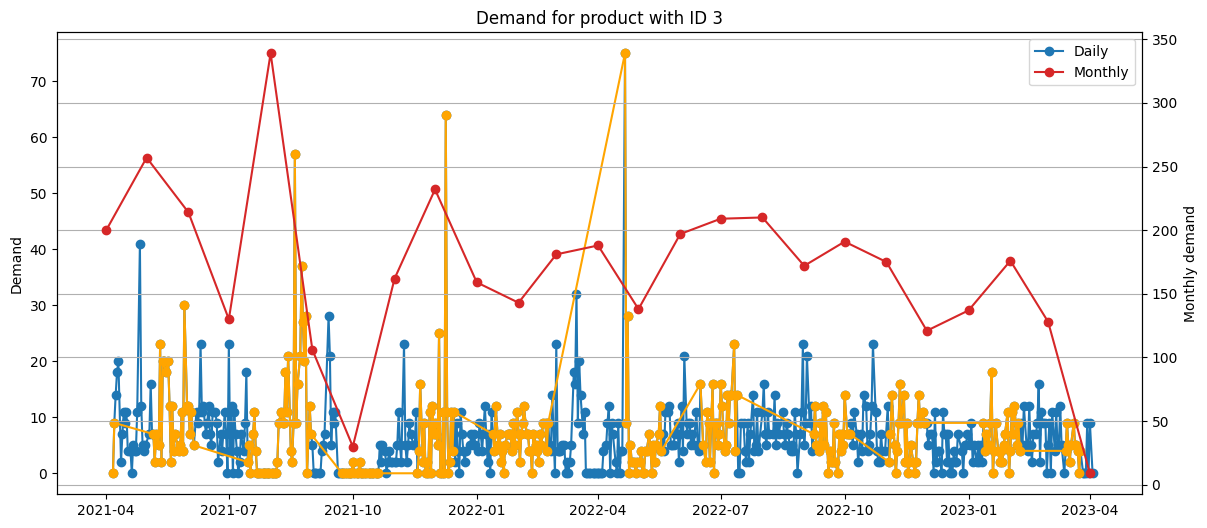

In [ ]:
print('Erratic')
plot_product_demand(dataset, random_erratic)

Statistics by product (Mean, Std., Min, Max, number of zero demand, stock-outs, ...)

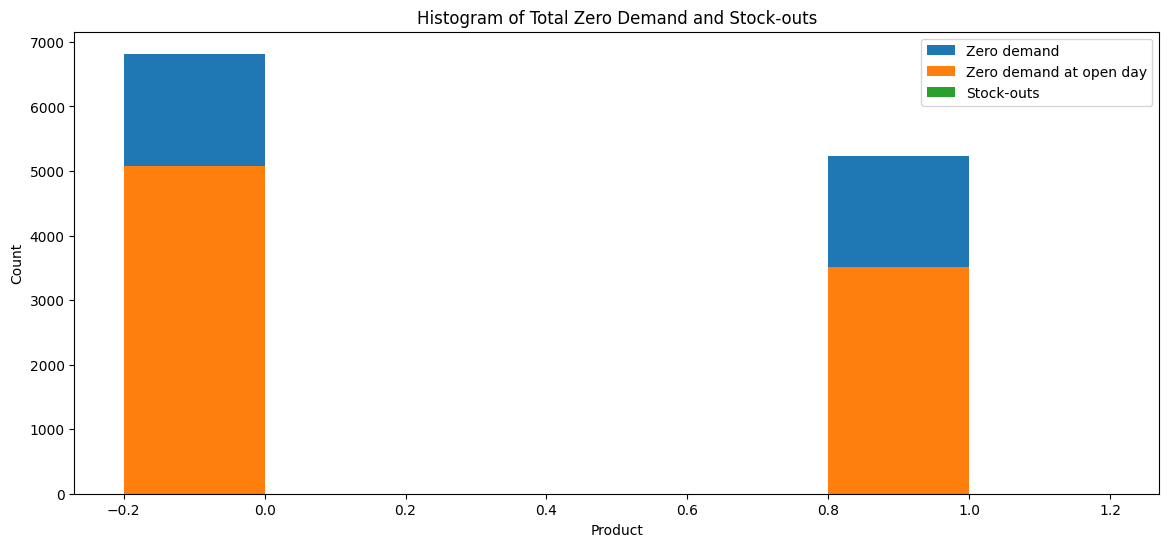

In [ ]:
plot_product_zero_demand_and_stock_outs(dataset, random_intermittent)

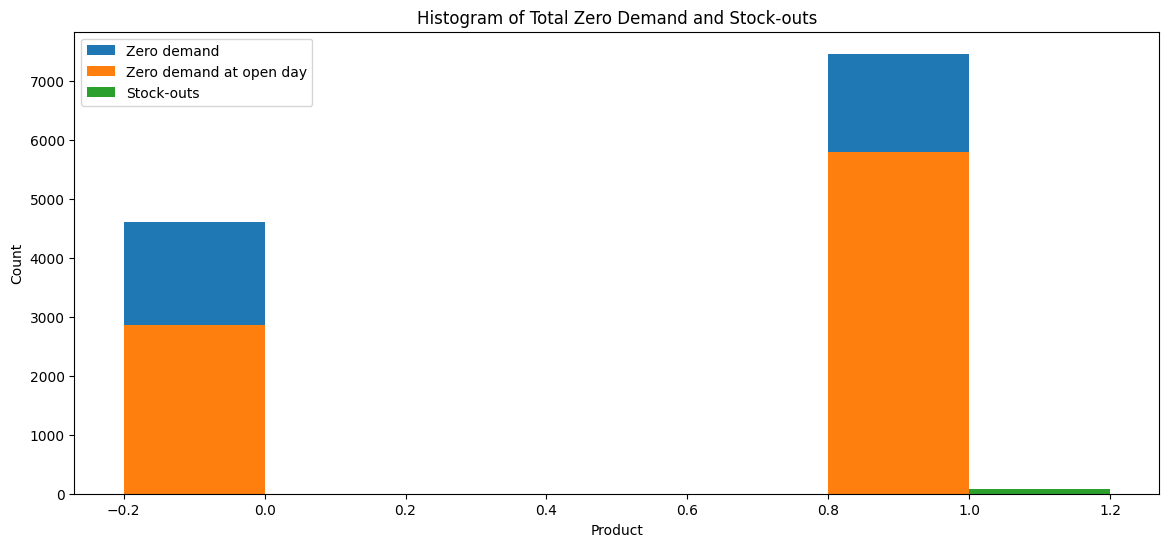

In [ ]:
plot_product_zero_demand_and_stock_outs(dataset, random_lumpy)

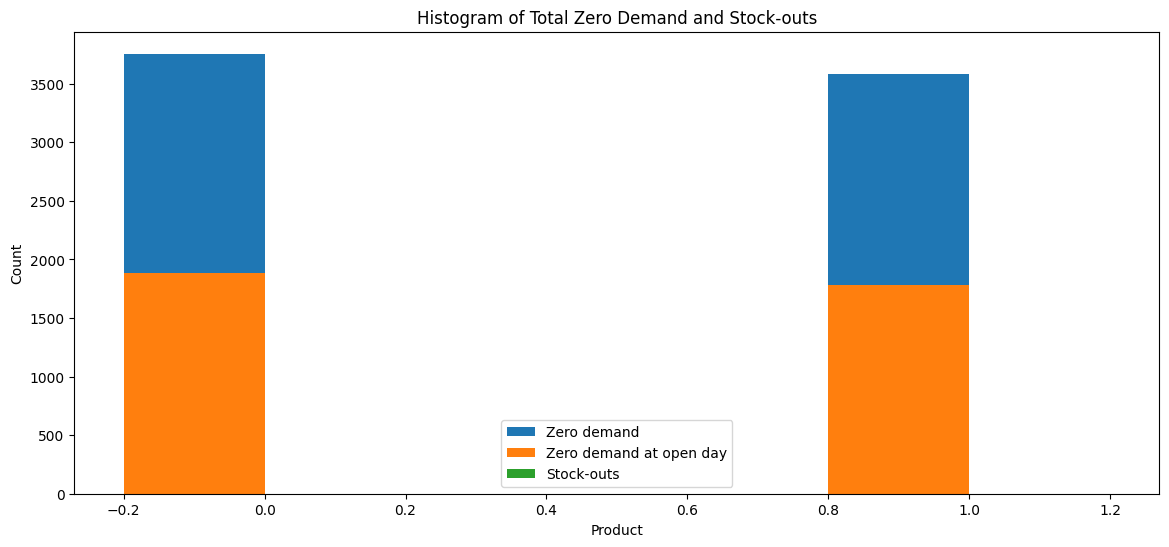

In [ ]:
plot_product_zero_demand_and_stock_outs(dataset, random_smooth)

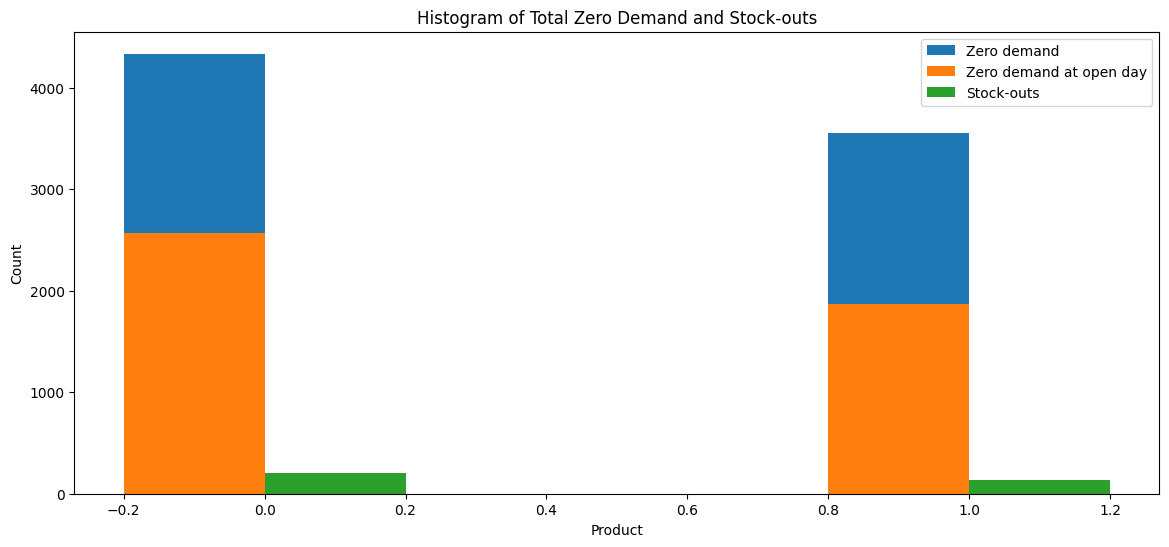

In [ ]:
plot_product_zero_demand_and_stock_outs(dataset, random_erratic)

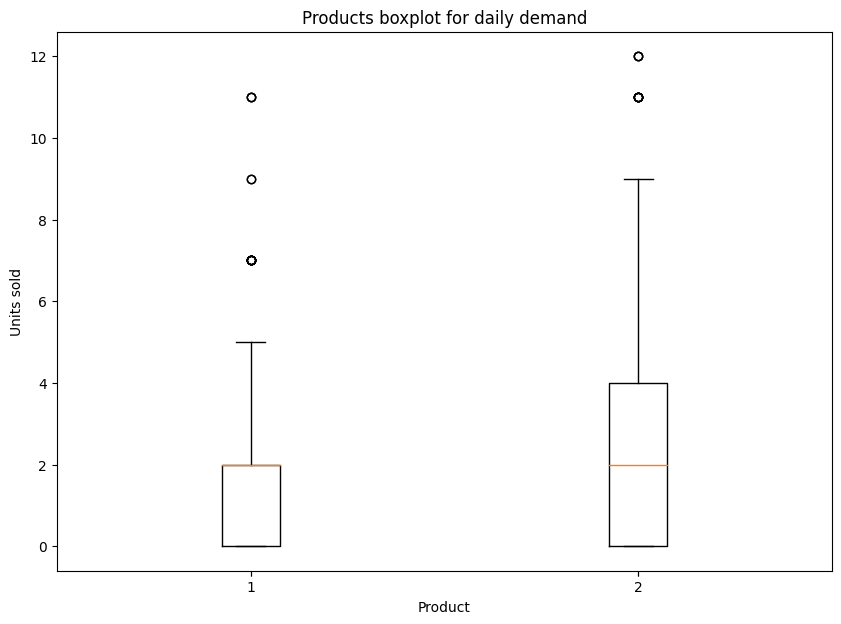

In [ ]:
plot_product_boxplots(dataset, random_intermittent)

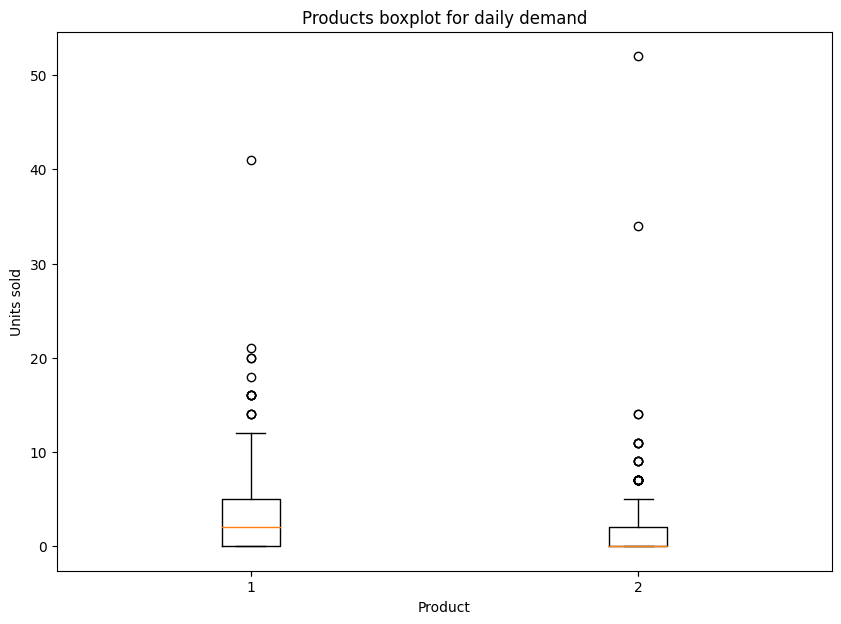

In [ ]:
plot_product_boxplots(dataset, random_lumpy)

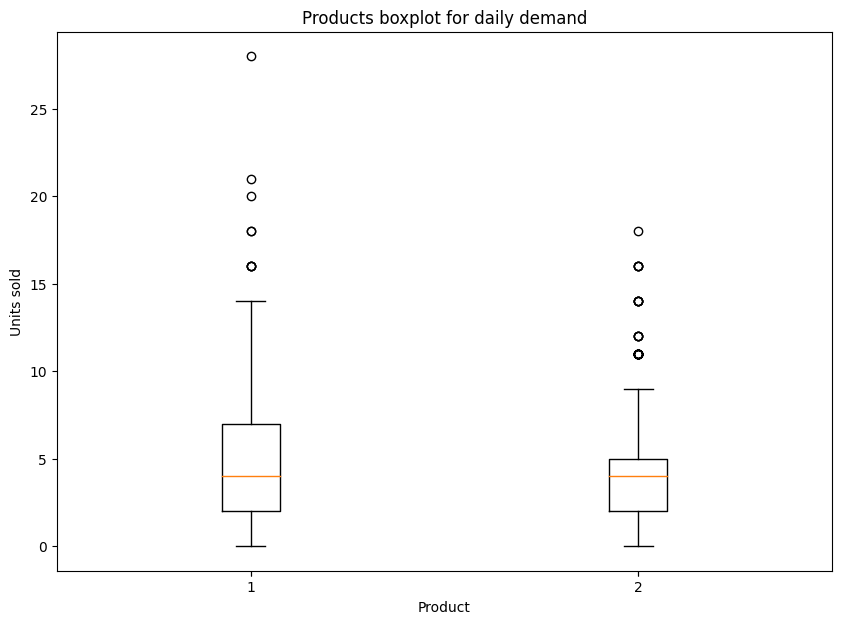

In [ ]:
plot_product_boxplots(dataset, random_smooth)

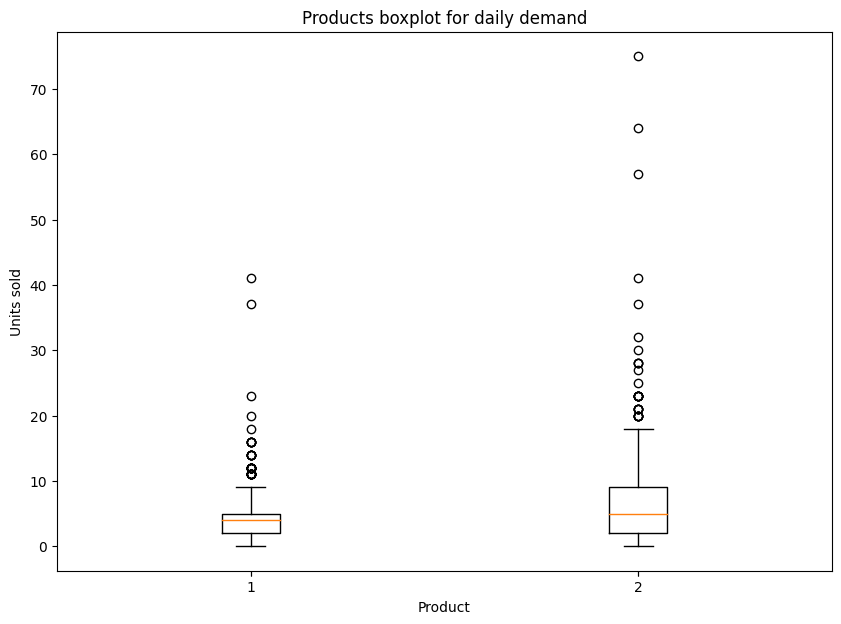

In [ ]:
plot_product_boxplots(dataset, random_erratic)

In [ ]:
# Remove stock-outs
dataset = dataset.loc[dataset['udsStock']!=0]
dataset = dataset.drop('udsStock', axis=1)

## Weekly datasets

### Non lagged

In [ ]:
dataset.head()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,promActive,promDuration,postPromPeriod,date,year,month,monthDay,weekDay,yearDay,ADI,CV2
0,1,20210404,0,0.0,1.0,1,27,0,2021-04-04,2021,4,4,6,94,1.144981,0.318285
1,1,20210405,0,0.0,1.0,1,27,0,2021-04-05,2021,4,5,0,95,1.144981,0.318285
2,1,20210406,16,1.0,0.0,1,27,0,2021-04-06,2021,4,6,1,96,1.144981,0.318285
3,1,20210407,21,1.0,0.0,1,27,0,2021-04-07,2021,4,7,2,97,1.144981,0.318285
4,1,20210408,4,1.0,0.0,0,0,1,2021-04-08,2021,4,8,3,98,1.144981,0.318285


In [ ]:
dataset_weekly = dataset.copy()
dataset_weekly = dataset_weekly.drop(columns=['promDuration', 'ADI', 'CV2', 'idSecuencia', 'weekDay', 'yearDay', 'monthDay', 'month'])

In [ ]:
dataset_weekly['week'] = dataset_weekly['date'].apply(lambda x: get_first_day_week(x))
dataset_weekly.head()

,producto,udsVenta,bolOpen,bolHoliday,promActive,postPromPeriod,date,year,week
0,1,0,0.0,1.0,1,0,2021-04-04,2021,2021-03-29
1,1,0,0.0,1.0,1,0,2021-04-05,2021,2021-04-05
2,1,16,1.0,0.0,1,0,2021-04-06,2021,2021-04-05
3,1,21,1.0,0.0,1,0,2021-04-07,2021,2021-04-05
4,1,4,1.0,0.0,0,1,2021-04-08,2021,2021-04-05


In [ ]:
dataset_weekly = dataset_weekly.groupby(['producto', 'week', 'year'], as_index=False).sum(numeric_only=False)

<ipython-input-37-b25c951f6847>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.sum is deprecated. In a future version, a TypeError will be raised. Before calling .sum, select only columns which should be valid for the function.
  dataset_weekly = dataset_weekly.groupby(['producto', 'week', 'year'], as_index=False).sum(numeric_only=False)


In [ ]:
dataset_weekly.head()

,producto,week,year,udsVenta,bolOpen,bolHoliday,promActive,postPromPeriod
0,1,2021-03-29,2021,0,0.0,1.0,1,0
1,1,2021-04-05,2021,61,5.0,2.0,3,4
2,1,2021-04-12,2021,51,6.0,1.0,0,3
3,1,2021-04-19,2021,55,6.0,1.0,0,0
4,1,2021-04-26,2021,52,5.0,2.0,0,0


## Save datasets

In [ ]:
dataset.to_csv('dataset.csv')
!cp dataset.csv "/content/drive/MyDrive/TFM/Datos/"

dataset_weekly.to_csv('dataset_weekly.csv')
!cp dataset_weekly.csv "/content/drive/MyDrive/TFM/Datos/"

Create a lagged dataset for ***udsVenta*** adding also covariates.

In [ ]:
complete_daily_file = '/content/drive/MyDrive/TFM/Datos/lagged_dataset_daily.csv'
complete_weekly_file = '/content/drive/MyDrive/TFM/Datos/lagged_dataset_weekly.csv'

f = open(complete_daily_file, "w")
f.truncate()
f.close()

f = open(complete_weekly_file, "w")
f.truncate()
f.close()


for producto in dataset['producto'].unique():
  create_product_lagged_matrix(dataset, producto, complete_daily_file, n_lags=7)
  create_product_lagged_matrix(dataset_weekly, producto, complete_weekly_file, n_lags=7)
